## 0. 모듈임포트
-----

In [4]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp  
import urllib.request
import os
import re
import time

from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from multiprocessing import Pool
from functools import partial 

## 1. 데이터 준비 및 전처리
-----

### 데이터 준비

#### 데이터 불러오기

In [7]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


98401개의 데이터를 갖고 있다.

In [8]:
data['headlines'][0]

'upGrad learner switches to career in ML & Al with 90% salary hike'

In [9]:
data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

#### 중복샘플 유무 확인

In [10]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


#### 중복데이터 제거

In [11]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### Null 유무확인 

In [12]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


Null 데이터는 없는 것으로 확인되었다.

### 텍스트 정규화 및 불용어 처리

#### 정규화사전 정의

In [13]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### NLTK 불용어 리스트 가져오기

In [14]:
nltk.download('stopwords')
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### 데이터 전처리 함수 정의 

In [15]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

#### 데이터 전처리 - 멀티프로세싱

In [16]:
# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print('<End_time>', time.time() - start_time, "seconds")
    return processed_data

In [17]:
clean_text = preprocess_data(data['text'])  
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) 
print(clean_summary)

<End_time> 184.8411796092987 seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenw

### 샘플의 최대길이 설정

#### 모델 길이분포

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553660024400163


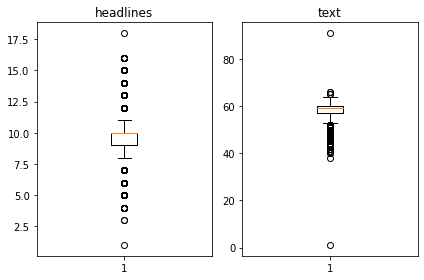

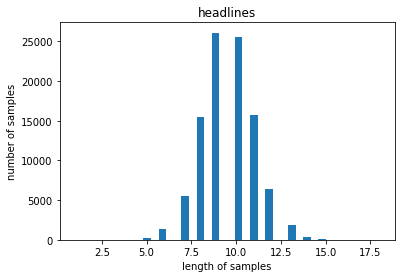

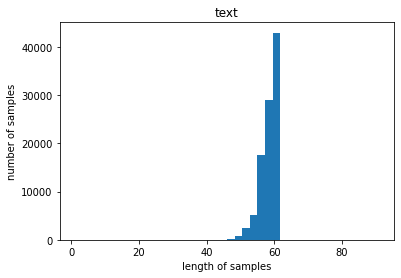

In [19]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### text와 headlines 최대 길이 설정

In [20]:
text_max_len = 60
headlines_max_len = 12

#### 전체 데이터중 최대길이 이하힌 데이터의 비율 구하는 함수 

In [21]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [22]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9768198454656364


#### 최대길이 초과하는 데이터 제거

In [23]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 95838


### 시작토큰과 종료토큰 추가

####  headlines에 시작 토큰과 종료 토큰 추가

In [24]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,sostoken Govt directs Alok Verma to join work ...,Govt directs Alok Verma to join work 1 day bef...


#### 인코더의 입력 및 디코더의 입력과 레이블 각각 Numpy 타입으로 저장

In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련데이터와 테스트 데이터 분리

#### encoder_input과 크기, 형태 같은 정수 시퀀스 생성

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[94817 33507  1012 ... 31380 76946 90274]


#### 생성한 정수시퀀스 이용해 샘플의 순서 섞기

In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

#### 테스트데이터 개수 정의

In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19167


#### 전체데이터를 훈련데이터와 테스트 데이터로 양분

In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76671
훈련 레이블의 개수 : 76671
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


### 훈련데이터와 테스트데이터 정수 인코딩

#### 훈련데이터의 text 컬럼 에서 단어집합 생성

In [30]:
src_tokenizer = Tokenizer() 
src_tokenizer.fit_on_texts(encoder_input_train)

#### 등장 빈도수 6회 이하인 단어의 통계정보 확인

In [31]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 90468
등장 빈도가 6번 이하인 희귀 단어의 수: 66023
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24445
단어 집합에서 희귀 단어의 비율: 72.97939602953531
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.785993124285878


#### 단어집합 크기 8000으로 제한하여 단어집합 재생성

In [32]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

#### 생성된 텍스트 시퀀스를 정수시퀀스로 변환

In [33]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[4214, 3836, 26, 1546, 3, 1139, 11, 1, 4432, 5, 2938, 6, 4788, 100, 1918, 1447, 87, 1292, 7590, 1, 5054, 12, 822, 2, 6327, 367, 19, 3, 3326, 215, 2365, 6, 74, 93, 3, 22, 3, 6091, 4592, 1089, 9, 248, 211, 29, 1, 3836, 10, 178, 25, 168, 4, 6328], [18, 7208, 271, 7, 532, 345, 3700, 3995, 3627, 999, 17, 2040, 291, 3164, 1472, 65, 200, 6789, 51, 21, 1, 267, 105, 19, 1, 73, 1046, 296, 79, 257, 768, 3, 1989, 2, 1627, 945, 4, 3701, 3, 1773, 637, 99, 6484, 4, 1, 2040, 184, 3165, 16, 3081], [1151, 1611, 8, 10, 11, 1047, 3874, 2029, 3, 570, 2, 1138, 203, 7, 1, 683, 21, 641, 5159, 3, 1378, 2, 1, 2, 1, 2331, 1404, 196, 84, 26, 2, 64, 224, 732, 11, 13, 1, 1728, 6, 11, 23, 112, 1982, 224, 1337, 32, 1151, 28, 282, 167, 1, 613, 5, 17, 73, 1047, 3014, 126, 1443]]


#### 훈련데이터의 headlines 컬럼에서 단어집합 생성

In [34]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

#### 빈도수 5회 이하인 단어들의 통계정보

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40432
등장 빈도가 5번 이하인 희귀 단어의 수: 29274
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11158
단어 집합에서 희귀 단어의 비율: 72.40304709141274
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.31509491052127


#### 단어집합 크기 2000으로 재생성한 후, 텍스트 시퀀스를 정수시퀀스로 변환

In [36]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1952, 1982, 7, 11], [1, 1278, 34, 1041, 9, 101, 5], [1, 1289, 11, 660, 3, 3, 901], [1, 245, 1109, 3, 674, 3, 306], [1, 1198, 487, 14, 7, 102]]
target
decoder  [[1952, 1982, 7, 11, 2], [1278, 34, 1041, 9, 101, 5, 2], [1289, 11, 660, 3, 3, 901, 2], [245, 1109, 3, 674, 3, 306, 2], [1198, 487, 14, 7, 102, 2]]


#### 훈련데이터와 테스트 데이터에서 길이가 1인 데이터(빈 샘플)를 제거

In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 14
삭제할 테스트 데이터의 개수 : 5
훈련 데이터의 개수 : 76657
훈련 레이블의 개수 : 76657
테스트 데이터의 개수 : 19162
테스트 레이블의 개수 : 19162


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 최대길이 보다 짧은 데이터들 패딩처리

In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 2. seq2seq 모델설계 및 훈련
-----

### 인코더 설계

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더 설계

#### 디코더의 임베딩 층

In [40]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#### 디코더의 출력층

In [41]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 디코더 출력층에 어텐션 메커니즘 적용

In [42]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련

#### 훈련수행

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
300/300 [==============================] - 268s 856ms/step - loss: 4.2705 - val_loss: 3.6727
Epoch 2/50
300/300 [==============================] - 255s 851ms/step - loss: 3.6140 - val_loss: 3.3500
Epoch 3/50
300/300 [==============================] - 254s 847ms/step - loss: 3.2870 - val_loss: 3.1238
Epoch 4/50
300/300 [==============================] - 250s 832ms/step - loss: 3.0625 - val_loss: 2.9607
Epoch 5/50
300/300 [==============================] - 250s 833ms/step - loss: 2.8939 - val_loss: 2.8507
Epoch 6/50
300/300 [==============================] - 250s 834ms/step - loss: 2.7630 - val_loss: 2.7535
Epoch 7/50
300/300 [==============================] - 250s 832ms/step - loss: 2.6534 - val_loss: 2.6780
Epoch 8/50
300/300 [==============================] - 252s 839ms/step - loss: 2.5618 - val_loss: 2.6321
Epoch 9/50
300/300 [==============================] - 251s 837ms/step - loss: 2.4851 - val_loss: 2.5777
Epoch 10/50
300/300 [==============================] - 251s 836m

#### 훈련데이터의 손실과 검증데이터의 손실 변화 시각화

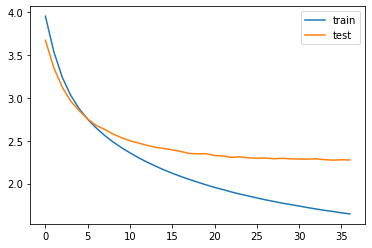

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 3. 인퍼런스 모델 구현
-----

### 단어사전 생성

In [49]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 모델  설계

#### 인코더와 디코더 설계

In [50]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#### 어텐션 메커니즘 적용한 출력층 설계 

In [51]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 인퍼런스 단계에서 단어시퀀스 완성하는 함수

In [55]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 4. 모델 테스트
-----

### text와 headlines의 정수시퀀스를 텍스트 시퀀스로 변환하는 함수

In [53]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

### 테스트 데이터 50개 샘플에 대한 실제 headline과 예측된 headline 비교

In [56]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : uber has applied for a patent for an ai system that can predict if a user is drunk while booking a cab according to the application the system would track users' speed including on the app walking speed booking location among others a passenger might only be with trained drivers and prevented from joining a 
실제 요약 : uber to an ai system to drunk 
예측 요약 :  uber to let users track videos via


원문 : the monthly grant for who scored 1 runs in a school match in 2016 has been temporarily this year by the mumbai cricket association had announced a monthly of ã¢ââ¹10 000 for five years for but he has not received the amount this year will review his performance this year before continuing the grant 
실제 요약 : run stopped by 
예측 요약 :  man receives 25 in ipl


원문 : union minister hegde on thursday apologised in the parliament for his remark on the constitution we are here to change the constitution hegde had claimed adding that people who believe in are unaware of their the lok sabha was on 

예측 요약 :  5 killed in and vehicle in j k


원문 : eight indians are among the 10 people who won nearly ã¢ââ¹1 8 crore one million each in a recent draw in abu dhabi the big ticket draw which was held at the abu dhabi international airport is the largest and longest running monthly draw for cash and luxury cars in the uae capital 
실제 요약 : 8 indians win ã¢ââ¹1 8 crore each in uae 
예측 요약 :  8 indians in ipl ticket for ã¢ââ¹6 crore


원문 : pm narendra modi was presented with united highest environmental honour of the in delhi by un secretary general on wednesday pm modi was recognised for his leadership of the international solar alliance and to eliminate single use plastic in india by 2022 he was among six winners including french president emmanuel macron 
실제 요약 : pm modi receives united highest honour 
예측 요약 :  pm modi with national award


원문 : shah rukh khan has revealed that his son gets really excited while telling him about abuses that he has learnt srk added i'm from delhi i've als

예측 요약 :  bjp demands action against rahul gandhi


원문 : national carrier air india's net loss to ã¢ââ¹3 crore in 2016 17 union minister jayant sinha informed the parliament on thursday the airline recorded operating profit of crore last fiscal compared to crore in 2015 16 he further said that as per the figures air india's total loans as on march 31 2017 are around crore 
실제 요약 : air india's net loss to ã¢ââ¹3 600 crore in 2016 17 
예측 요약 :  air india ã¢ââ¹3 crore in 2016 17


원문 : calling karnataka governor a of bjp congress spokesperson randeep surjewala on wednesday said the governor has his office by giving 15 days time governor is encouraging horse trading by bjp leaders the jd s congress cm candidate hd kumaraswamy said this comes after bjp's bs yeddyurappa was formally invited to form the government 
실제 요약 : karnataka governor has his office congress 
예측 요약 :  cong has 15 to k'taka cm on k'taka polls


원문 : actor shahid kapoor while reacting to the burning down of the sets of 

## 5. 추출적 요약
-----

### Summa.summarize 모듈임포트

In [84]:
import requests
from summa.summarizer import summarize

### 추출적 분석용 test컬럼 데이터 생성

In [193]:
# 데이터 불러오기
new_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
new_data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

# 데이터 최대길이 초과한 데이터 제거
below_threshold_len(text_max_len, new_data['text'])
below_threshold_len(headlines_max_len, new_data['headlines'])

# 추출적 분석용 input_test 데이터 생성 
new_encoder_input = np.array(new_data['text'])
new_encoder_input = new_encoder_input[indices]
new_encoder_input_test = new_encoder_input[-n_of_val:]

new_encoder_input_test[0] 

전체 샘플수 : 98360
전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9768198454656364


'A Zomato user recently shared screenshots of a text conversation with Zomato\'s customer care over a delayed food delivery order. The startup\'s customer care sent a sad emoticon to the user instead of the usual formal response. When the user asked, "Should we really break up now," Zomato replied, "Noooo, I can\'t loose you".'

### 추상적 headline 과 추출적 headline 비교

In [264]:
# 50개의 문장을 대상으로 추상적 기법과 추출적 기법 비교
for i in range(50, 100):
    text = '\r\n\r\n'.join(new_encoder_input_test[i].split('.')) # 원문에 문단 구분추가 
    print(f'<< {i} >>---------------------------------------------------------------------')
    print(f'[원문]\n: ' + text) 
    print('[추상적 headline]\n: '+ decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    if len(text) >= 100: 
        ratio, words = 0.5, 16
    elif len(text) >= 50:
        ratio, words = 0.75, 10
    else: ratio, words = 1.0, 5 
    print('ratio, len(text),word:',ratio,len(text),words)
    print('[추출적 headline]\n: '+ summarize(text, ratio=ratio, words=words))
    
    # 50개 출력시 종료
    if idx == 99:
        print(f'<<<<{i} headlines are predicted>>>>')
        break

<< 50 >>---------------------------------------------------------------------
[원문]
: Reacting to Senegal coach Aliou CissÃÂ©'s celebration during the team's victory against Poland at the 2018 FIFA World Cup, a user tweeted, "CissÃÂ© is me when there's free food at work

" Other users wrote, "Me when I wake up early but realise I've 10 more minutes of sleep before the alarm rings," and "CissÃÂ©'s like: 'Celebrate

 But make it fashion'

" 
[추상적 headline]
:  uber to let users track videos via
ratio, len(text),word: 0.5 366 16
[추출적 headline]
: Reacting to Senegal coach Aliou CissÃÂ©'s celebration during the team's victory against Poland at the 2018 FIFA World Cup, a user tweeted, "CissÃÂ© is me when there's free food at work
<< 51 >>---------------------------------------------------------------------
[원문]
: Security footage from a State Bank of India branch in Pathankot showed a naked man stealing the guard's shoes, two pressure cookers, and a pan, instead of money

 He had entered 

[추상적 headline]
:  sc asks to shelter to shelter
ratio, len(text),word: 0.5 339 16
[추출적 headline]
: The child was tortured, starved and forced to consume liquor before he was thrown into a water tank, police said
<< 63 >>---------------------------------------------------------------------
[원문]
: The New Delhi Municipal Corporation has announced that Gole Market near Connaught Place will be transformed into a museum to house materials of cultural and historical importance related to Delhi

 The museum will reportedly have four components including a photo exhibition, documentaries, freedom movement, and paintings and sculpture

 The project is expected to be completed by September 2018

 
[추상적 headline]
:  ex football captain son for
ratio, len(text),word: 0.5 405 16
[추출적 headline]
: The New Delhi Municipal Corporation has announced that Gole Market near Connaught Place will be transformed into a museum to house materials of cultural and historical importance related to Delhi
<< 64 >>--

[추상적 headline]
:  ram temple not to be in 2019 polls
ratio, len(text),word: 0.5 354 16
[추출적 headline]
: A senior assistant manager at a bank in West Bengal stole coins worth Ã¢ÂÂ¹84 lakh over a period of 17 months to buy lottery tickets
<< 75 >>---------------------------------------------------------------------
[원문]
: Technology giant Microsoft has launched an AI-enabled smart speaker called 'Invoke' priced at $199 (Ã¢ÂÂ¹13,000) to compete with Amazon's Echo and Google Home

 Microsoft partnered with audio products specialist Harman Kardon to build the speaker which comes with Microsoft's digital assistant Cortana

 'Invoke' has touch controls, and features an aux port along with the Bluetooth support


[추상적 headline]
:  indian origin man jailed for 20 yrs for wife
ratio, len(text),word: 0.5 399 16
[추출적 headline]
: Technology giant Microsoft has launched an AI-enabled smart speaker called 'Invoke' priced at $199 (Ã¢ÂÂ¹13,000) to compete with Amazon's Echo and Google Home
<< 76 >>-

[추상적 headline]
:  flipkart payments tech firms among online
ratio, len(text),word: 0.5 366 16
[추출적 headline]
: 
<< 88 >>---------------------------------------------------------------------
[원문]
: A five-judge Supreme Court bench will hear the petition moved by two Congress MPs against Rajya Sabha Chairman Venkaiah Naidu's rejection of impeachment motion against Chief Justice Dipak Misra

 The bench does not include the four senior SC judges who held a press conference against Misra

 The MPs' petition has called Naidu's rejection arbitrary and in violation of the Constitution

 
[추상적 headline]
:  ec rejects cong candidate for seat seat
ratio, len(text),word: 0.5 395 16
[추출적 headline]
: A five-judge Supreme Court bench will hear the petition moved by two Congress MPs against Rajya Sabha Chairman Venkaiah Naidu's rejection of impeachment motion against Chief Justice Dipak Misra
<< 89 >>---------------------------------------------------------------------
[원문]
: At least ten people were 

[추상적 headline]
:  us report may have been in report
ratio, len(text),word: 0.5 373 16
[추출적 headline]
: 52 Mbps, nearly double its speed from last year
97 Mbps and Delhi stood seventh at 6
69 Mbps


추출적 분석의 경우 